1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib import cm
%matplotlib inline

In [2]:
def f(x): # six-hump camelback function
    z = (4 - 2.1*x[0]**2 + (x[0]**4 / 3))*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2
    return z

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
x, y = np.meshgrid(x, y)
t = np.array([x,y])

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [ 2.17782634e-03, -1.44126560e-04]])
     fun: -1.0316284534898565
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 3
  status: 0
 success: True
       x: array([ 0.08984201, -0.71265645]) 

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-6.21111406e-04,  4.70877838e-05]])
     fun: -1.0316284534898421
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 3
  status: 0
 success: True
       x: array([-0.08984201,  0.71265634])


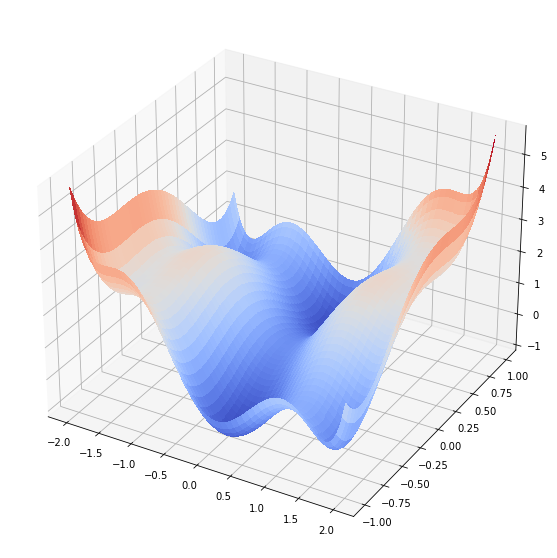

In [3]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10)) 
surf = ax.plot_surface(x, y, f(t), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False) # plot 3D of the function f

solution1 = optimize.minimize(f, (1,1), method='Powell') # first minima 
solution2 = optimize.minimize(f, (0,0), method='Powell') # second minima
print(solution1, "\n")
print(solution2)
# solutions are compatible with the ones can be found online

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [4]:
T_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
T_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
t = np.arange(12) + 1 # number of each month

In [5]:
from math import pi
def f(x, a, b, c, d): # sinusoidal function due to the periodicity of the system
    return a*np.sin((2*pi)*((1/b)*x + c))+d

popt_max, pcov_max = optimize.curve_fit(f, t, T_max, p0=[-10, 12, 4, 30], full_output=False)
print("parameters:\n", popt_max)
print("covariance matrix:\n", pcov_max)
print("a_max = %.2f +- %.2f" % (popt_max[0], np.sqrt(pcov_max[0,0])))
print("b_max = %.2f +- %.2f" % (popt_max[1], np.sqrt(pcov_max[1,1])))
print("c_max = %.2f +- %.2f" % (popt_max[2], np.sqrt(pcov_max[2,2])))
print("d_max = %.2f +- %.2f" % (popt_max[3], np.sqrt(pcov_max[3,3])))

print("\n")

popt_min, pcov_min = optimize.curve_fit(f, t, T_min, p0=[-25, 12, 4, -30], full_output=False)
print("parameters:\n", popt_min)
print("covariance matrix:\n", pcov_min)
print("a_min = %.2f +- %.2f" % (popt_min[0], np.sqrt(pcov_min[0,0])))
print("b_min = %.2f +- %.2f" % (popt_min[1], np.sqrt(pcov_min[1,1])))
print("c_min = %.2f +- %.2f" % (popt_min[2], np.sqrt(pcov_min[2,2])))
print("d_min = %.2f +- %.2f" % (popt_min[3], np.sqrt(pcov_min[3,3])))

parameters:
 [-10.58169953  10.60857437   4.11628857  27.94963536]
covariance matrix:
 [[ 0.1681645  -0.01538384 -0.00083201 -0.00655239]
 [-0.01538384  0.14396026  0.00844577 -0.11468343]
 [-0.00083201  0.00844577  0.00054101 -0.00669063]
 [-0.00655239 -0.11468343 -0.00669063  0.18339758]]
a_max = -10.58 +- 0.41
b_max = 10.61 +- 0.38
c_max = 4.12 +- 0.02
d_max = 27.95 +- 0.43


parameters:
 [-25.14962039  10.44897505   4.06734976 -36.71257115]
covariance matrix:
 [[ 1.72807325e+00 -4.31356239e-03  5.83157168e-04 -1.89185586e-01]
 [-4.31356239e-03  1.60248925e-01  9.84448791e-03 -2.78033826e-01]
 [ 5.83157168e-04  9.84448791e-03  6.85237761e-04 -1.65822882e-02]
 [-1.89185586e-01 -2.78033826e-01 -1.65822882e-02  1.41860485e+00]]
a_min = -25.15 +- 1.31
b_min = 10.45 +- 0.40
c_min = 4.07 +- 0.03
d_min = -36.71 +- 1.19


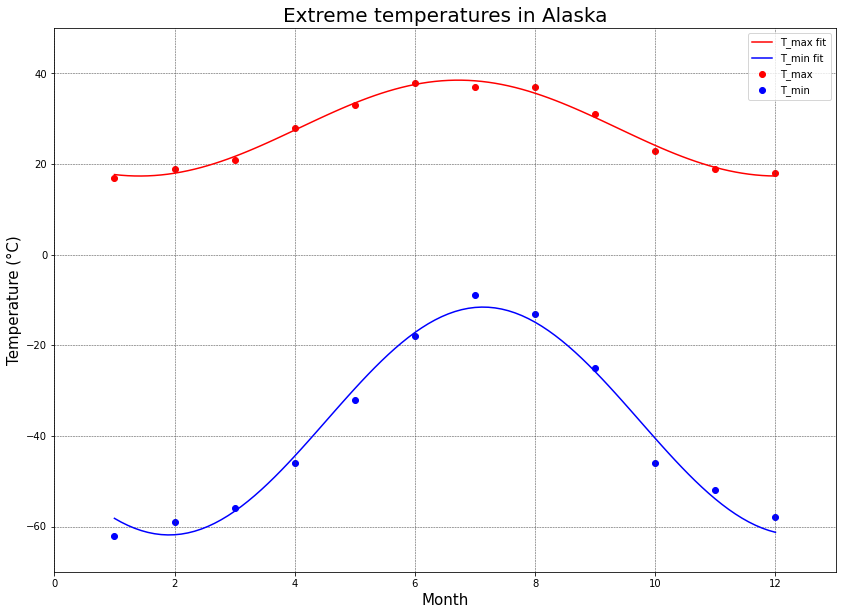

In [6]:
t_ax = np.linspace(1,12,100) # grid for plotting f
y_max = f(t_ax, popt_max[0], popt_max[1], popt_max[2], popt_max[3]) # red sinusoid
y_min = f(t_ax, popt_min[0], popt_min[1], popt_min[2], popt_min[3]) # blue sinusoid
fig, ax = plt.subplots(figsize = (14,10))
ax.scatter(t, T_max, color = 'red', label = "T_max")
ax.scatter(t, T_min, color = 'blue', label = "T_min")
ax.plot(t_ax, y_max, color = 'red', label = "T_max fit")
ax.plot(t_ax, y_min, color = 'blue', label = "T_min fit")
ax.set_xlabel("Month", fontsize=15)
ax.set_ylabel("Temperature (°C)", fontsize=15)
ax.set_title("Extreme temperatures in Alaska", fontsize=20)
ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)
ax.set_xlim(0, 13)
ax.set_ylim(-70, 50)
ax.legend()
# the problem is that the periods b_max, b_min are roughly 10 months and half,
# when they must be near 12 months
# This issue is motivated by the fact that summer lasts less than winter

# c_max and c_min are compatible so the time offset of the two curves is similar

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [7]:
import pandas as pd
data = np.load("residuals_261.pkl", allow_pickle = True)
df = pd.DataFrame(data.item())
df_f = df[4 - (df['residuals'])**2 > 0]

mu = -0.085 +- 0.004
sigma = 0.225 +- 0.004
A = 364 +- 6


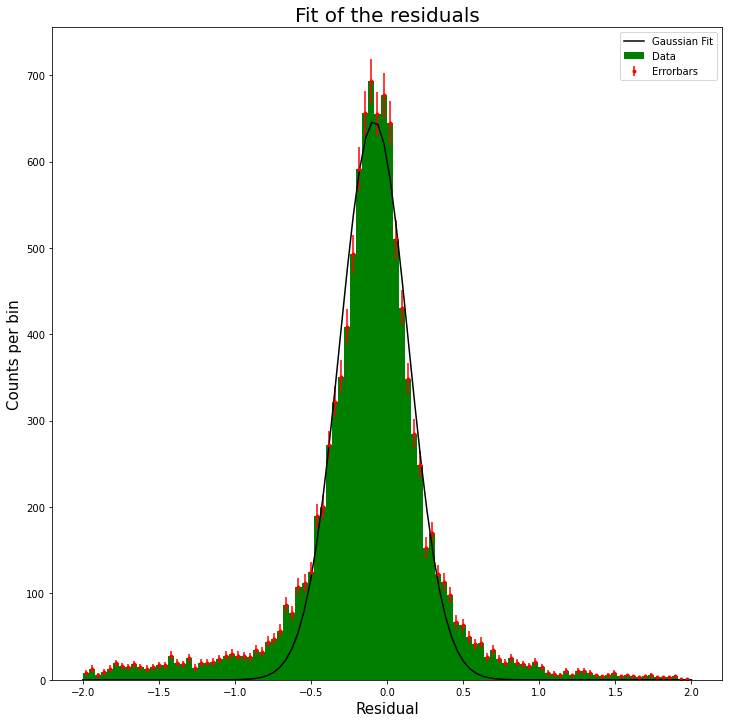

In [8]:
from scipy.stats import norm
import scipy
def gauss(x, mu, sigma, A): # gaussian function picked to be fitted
    return A*norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize = (12,12))
y, bin_edges, _ = ax.hist(df_f["residuals"], bins = 100, color = 'green', label = "Data")
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1]) 

popt, pcov = optimize.curve_fit(gauss, bincenters, y, p0=[0, 0.8, 5000], full_output=False)
print("mu = %.3f +- %.3f" % (popt[0], np.sqrt(pcov[0,0])))
print("sigma = %.3f +- %.3f" % (popt[1], np.sqrt(pcov[1,1])))
print("A = %.0f +- %.0f" % (popt[2], np.sqrt(pcov[2,2])))

ax.errorbar(bincenters, y, np.sqrt(y), ecolor = 'r', linestyle = 'none', fmt='.-r', label = 'Errorbars')
x_lin = np.linspace(-2, 2, 100)
ax.plot(x_lin, gauss(x_lin, popt[0], popt[1], popt[2]), color = 'black', label = "Gaussian Fit")
ax.set_xlabel("Residual", fontsize=15)
ax.set_ylabel("Counts per bin", fontsize=15)
ax.set_title("Fit of the residuals", fontsize=20)
ax.legend()

In [9]:
ssr = np.sum((y - gauss(bincenters, popt[0], popt[1], popt[2]))**2)
tss = np.sum((np.mean(y) - y)**2)

rsq = 1 - ssr / tss

print("R2 =", rsq, "\nR =", np.sqrt(rsq)) # R2 not so bad but the fit looks awful

R2 = 0.9774018365950032 
R = 0.9886363520501374


In [10]:
sigma_y = np.sqrt(np.abs(y)) 
sigma_y[sigma_y == 0] = 1 # fake the error of the bins with zero entries
ndof = len(y) - 3
chi2 = np.sum(((y - gauss(bincenters, popt[0], popt[1], popt[2]))**2) / sigma_y**2)
pvalue = 1 - scipy.stats.chi2.cdf(chi2, ndof)
print("n_dof =", ndof)
print("chi2 =", chi2)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

n_dof = 97
chi2 = 1343.3352735450667
p-value = 0.0


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [11]:
data = pd.read_csv("munich_temperatures_average_with_bad_data.txt", sep=" ", header=None)
df = pd.DataFrame(data)
data = (df.to_numpy()).T
df # 0 is x axis and 1 the y axis

,0,1
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


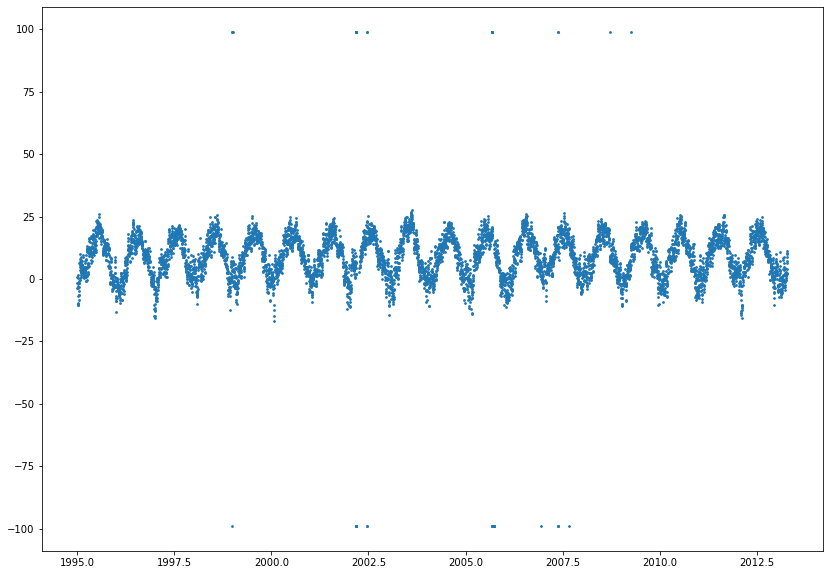

In [12]:
fig, ax = plt.subplots(figsize = (14,10))
ax.scatter(data[0], data[1], s = 3) # lots of bad points at 100 and -100 degrees, problems in the strumentation

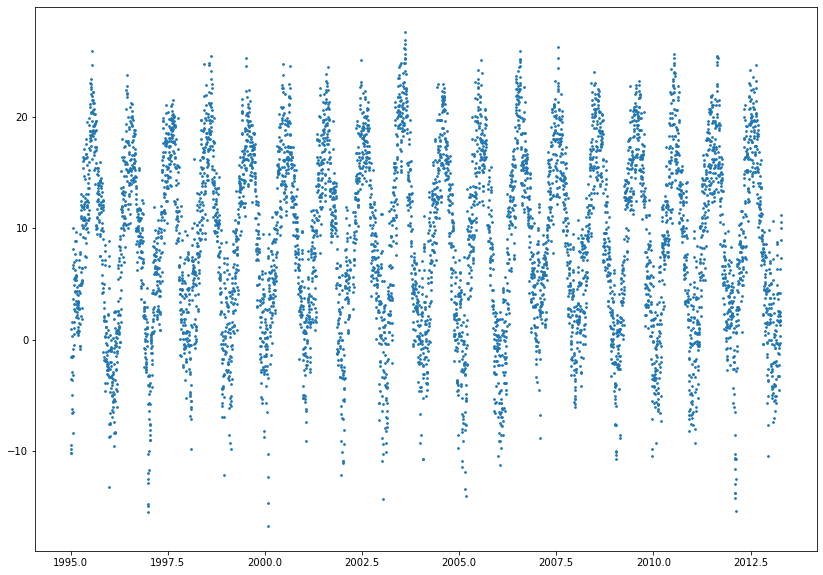

In [13]:
df_f = df[abs(df[1]) < 50] # filtered dataset
data_f = df_f.to_numpy().T
fig, ax = plt.subplots(figsize = (14,10))
ax.scatter(data_f[0], data_f[1], s = 3)

In [14]:
def f(t, a, b, c): # first function with fixed period
    return a*np.cos(2*pi*t + b)+c

popt, pcov = optimize.curve_fit(f, data_f[0], data_f[1], p0=[16, 0, 7], full_output=False) # the fit is done on all years
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
print("a = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("b = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))
print("c = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))

parameters:
 [-9.95518347 -0.25296471  9.04084545]
covariance matrix:
 [[ 4.33827104e-03 -2.06725526e-06 -4.67784572e-05]
 [-2.06725526e-06  4.43023146e-05 -2.58482631e-06]
 [-4.67784572e-05 -2.58482631e-06  2.18211979e-03]]
a = -9.96 +- 0.07
b = -0.25 +- 0.01
c = 9.04 +- 0.05


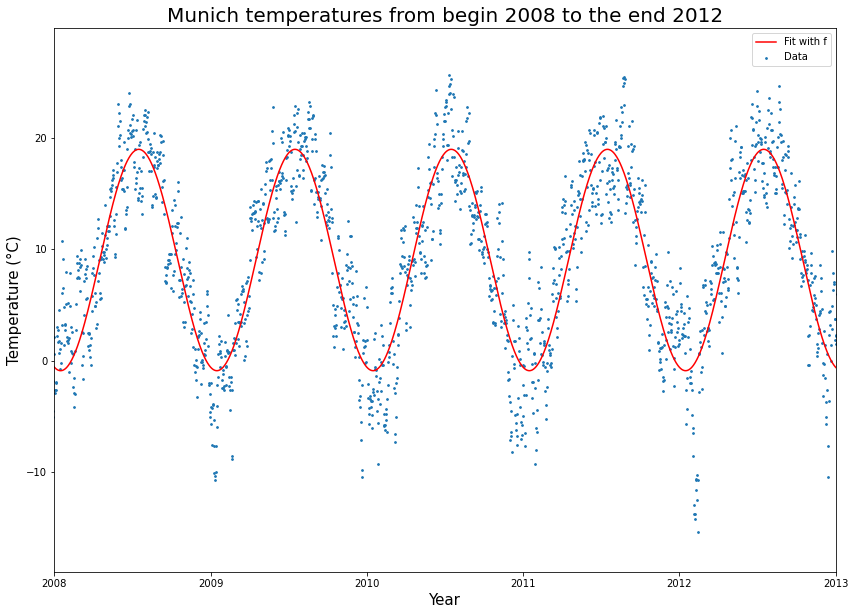

In [15]:
y1 = f(data_f[0], popt[0], popt[1], popt[2])
fig, ax = plt.subplots(figsize = (14,10))
ax.scatter(data_f[0], data_f[1], s = 3, label = "Data")
ax.plot(data_f[0], y1, color = 'red', label = "Fit with f")
ax.set_xlim([2008, 2013])
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Temperature (°C)", fontsize=15)
ax.set_title("Munich temperatures from begin 2008 to the end 2012", fontsize=20)
ax.legend()

In [16]:
T_av = df_f.mean().iloc[1]
print("Overall average temperature of Munich:")
print("%.2f °C" % (T_av))

Overall average temperature of Munich:
8.93 °C


In [17]:
print("Highest average temperature of Munich: %.2f °C" % (popt[2]+abs(popt[0])))
print("Lowest average temperature of Munich: %.2f °C"% (popt[2]-abs(popt[0])))

Highest average temperature of Munich: 19.00 °C
Lowest average temperature of Munich: -0.91 °C


In [18]:
print("The offset is %.2f months, so the minima is at the middle of January" % (12*popt[1]/(2*pi))) 
# b parameter tells that the minimum is shifted and it is not the 1 January

The offset is -0.48 months, so the minima is at the middle of January


In [19]:
def g(t, a, b, c, d): # second function with tuning period
    return a*np.cos(2*pi*b*t + c)+d

popt, pcov = optimize.curve_fit(g, data_f[0], data_f[1], p0=[16, 1, 0, 7], full_output=False) # the fit is done on all years
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
print("a = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("b = %.4f +- %.4f" % (popt[1], np.sqrt(pcov[1,1])))
print("c = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))
print("d = %.2f +- %.2f" % (popt[3], np.sqrt(pcov[3,3])))

parameters:
 [-9.95538278  0.99976014  2.76764967  9.03978537]
covariance matrix:
 [[ 4.34388040e-03 -4.89804351e-07  6.16567335e-03 -4.84911903e-05]
 [-4.89804351e-07  4.00398262e-08 -5.04193355e-04  1.78112631e-07]
 [ 6.16567335e-03 -5.04193355e-04  6.34899640e+00 -2.24538604e-03]
 [-4.84911903e-05  1.78112631e-07 -2.24538604e-03  2.18275326e-03]]
a = -9.96 +- 0.07
b = 0.9998 +- 0.0002
c = 2.77 +- 2.52
d = 9.04 +- 0.05


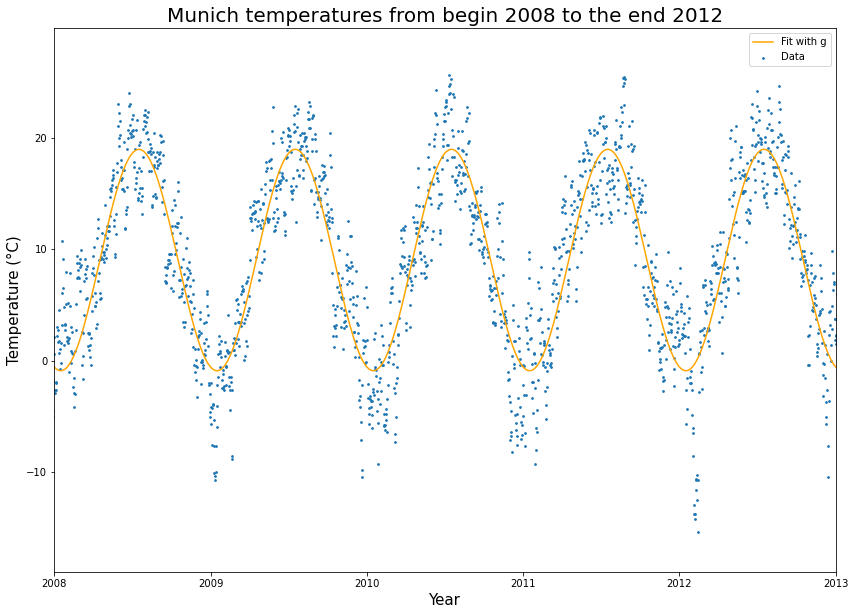

In [20]:
y2 = g(data_f[0], popt[0], popt[1], popt[2], popt[3])
fig, ax = plt.subplots(figsize = (14,10))
ax.scatter(data_f[0], data_f[1], s = 3, label = "Data")
ax.plot(data_f[0], y2, color = 'orange', label = "Fit with g")
ax.set_xlim([2008, 2013])
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Temperature (°C)", fontsize=15)
ax.set_title("Munich temperatures from begin 2008 to the end 2012", fontsize=20)
ax.legend()

In [21]:
ndof_1 = 3 - 1
ndof_2 = 4 - 1
ssr1 = np.sum((data_f[1] - y1)**2)
ssr2 = np.sum((data_f[1] - y2)**2)
print("RSS for the function f: %.0f" % (ssr1))
print("RSS for the function g: %.0f" % (ssr2)) # very similar each other

RSS for the function f: 95529
RSS for the function g: 95508


In [22]:
from scipy import stats
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print("Test fixed period vs tuning period:")
cl = Ftest(ssr1, ssr2, ndof_1, ndof_2, len(data_f[0]), verbose=True)

Test fixed period vs tuning period:
CL: 0.231 , additional parameter necessary: NO
